# 감성 분석 모델 학습 및 추론

### 1. 데이터 로드

In [52]:
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [53]:
import os, tarfile, zipfile, json, pandas as pd
from pathlib import Path

TAR_PATH = r"./download (1).tar"  
OUT_DIR  = r"./emotout"                
INCLUDE_SS = False  

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# .tar 풀기
extract_root = Path(OUT_DIR) / "extracted"
extract_root.mkdir(exist_ok=True, parents=True)
print(f"TAR 추출 중: {TAR_PATH}")
with tarfile.open(TAR_PATH, "r") as tar:
    tar.extractall(path=extract_root)
print(f"추출 완료: {extract_root}")

# 2) 학습/검증 경로 찾기
base = extract_root / "018.감성대화"
train_dir = base / "Training_221115_add" / "라벨링데이터"
valid_dir = base / "Validation_221115_add" / "라벨링데이터"
candidates = []
for d in [train_dir, valid_dir]:
    if d.exists():
        candidates.extend(sorted(d.glob("*.zip.part*")))

if not candidates:
    raise FileNotFoundError("라벨링 zip(.zip.part*) 파일을 찾지 못했습니다.")

def rows_from_zip(zip_path: Path, include_ss=False):
    rows = []
    print(f"ZIP 열기 시도: {zip_path.name}")
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            names = zf.namelist()
            for name in names:
                if not name.lower().endswith(".json"):
                    continue
                raw = zf.read(name)
                data = json.loads(raw.decode("utf-8"))
                for ex in data:
                    profile = ex.get("profile", {})
                    emotion = profile.get("emotion", {})
                    emotion_type = emotion.get("type")          
                    emotion_id   = emotion.get("emotion-id")    
                    persona_id   = profile.get("persona-id")

                    talk = ex.get("talk", {})
                    talk_id  = talk.get("id", {}).get("talk-id")
                    content  = talk.get("content", {})

                    for k, v in content.items():
                        if not isinstance(v, str) or not v.strip():
                            continue
                        if k.startswith("HS"):
                            rows.append({
                                "text": v.strip(),
                                "label": emotion_type,
                                "emotion_id": emotion_id,
                                "persona_id": persona_id,
                                "talk_id": talk_id,
                                "utterance_role": k,
                                "speaker": "user"
                            })
                        elif include_ss and k.startswith("SS"):
                            rows.append({
                                "text": v.strip(),
                                "label": emotion_type,
                                "emotion_id": emotion_id,
                                "persona_id": persona_id,
                                "talk_id": talk_id,
                                "utterance_role": k,
                                "speaker": "assistant"
                            })
        return rows, None
    except Exception as e:
        return [], str(e)

all_rows = []
errors = []

for zp in candidates:
    rows, err = rows_from_zip(zp, include_ss=INCLUDE_SS)
    if err:
        errors.append((zp.name, err))
    else:
        all_rows.extend(rows)

# 데이터프레임으로 변환 & 저장
if not all_rows:
    print("유효한 데이터가 한 건도 수집되지 않았습니다.")
else:
    df = pd.DataFrame(all_rows)
    kind = "HS_only" if not INCLUDE_SS else "HS_SS"
    out_csv = Path(OUT_DIR) / f"aihub_emotion_{kind}.csv"
    df.to_csv(out_csv, index=False, encoding="utf-8-sig")


TAR 추출 중: ./download (1).tar
추출 완료: emotout\extracted
ZIP 열기 시도: 감성대화말뭉치(최종데이터)_Training.zip.part0


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14928\3456344110.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_root)


ZIP 열기 시도: 감성대화말뭉치(최종데이터)_Validation.zip.part0


In [54]:
df.head(10)

,text,label,emotion_id,persona_id,talk_id,utterance_role,speaker
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,E18,S06_D02_E18,Pro_05349,Pro_05349_00053,HS01,user
1,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,E18,S06_D02_E18,Pro_05349,Pro_05349_00053,HS02,user
2,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,E18,S06_D02_E18,Pro_05349,Pro_05349_00049,HS01,user
3,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,E18,S06_D02_E18,Pro_05349,Pro_05349_00049,HS02,user
4,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,E18,S06_D02_E18,Pro_05349,Pro_05349_00077,HS01,user
5,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,E18,S06_D02_E18,Pro_05349,Pro_05349_00077,HS02,user
6,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,E18,S06_D02_E18,Pro_05349,Pro_05349_00064,HS01,user
7,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,E18,S06_D02_E18,Pro_05349,Pro_05349_00064,HS02,user
8,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,E18,S06_D02_E18,Pro_05349,Pro_05349_00039,HS01,user
9,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,E18,S06_D02_E18,Pro_05349,Pro_05349_00039,HS02,user


In [55]:
emotion_mapper = {
    # 분노 (E10~E19)
    "E10": "분노",
    "E11": "툴툴대는",
    "E12": "좌절한",
    "E13": "짜증내는",
    "E14": "방어적인",
    "E15": "악의적인",
    "E16": "안달하는",
    "E17": "구역질 나는",
    "E18": "노여워하는",
    "E19": "성가신",

    # 슬픔 (E20~E29)
    "E20": "슬픔",
    "E21": "실망한",
    "E22": "비통한",
    "E23": "후회되는",
    "E24": "우울한",
    "E25": "마비된",
    "E26": "염세적인",
    "E27": "눈물이 나는",
    "E28": "낙담한",
    "E29": "환멸을 느끼는",

    # 불안 (E30~E39)
    "E30": "불안",
    "E31": "두려운",
    "E32": "스트레스 받는",
    "E33": "취약한",
    "E34": "혼란스러운",
    "E35": "당혹스러운",
    "E36": "회의적인",
    "E37": "걱정스러운",
    "E38": "조심스러운",
    "E39": "초조한",

    # 상처 (E40~E49)
    "E40": "상처",
    "E41": "질투하는",
    "E42": "배신당한",
    "E43": "고립된",
    "E44": "충격 받은",
    "E45": "불우한",
    "E46": "희생된",
    "E47": "억울한",
    "E48": "괴로워하는",
    "E49": "버려진",

    # 당황 (E50~E59)
    "E50": "당황",
    "E51": "고립된(당황)",
    "E52": "남의 시선 의식하는",
    "E53": "외로운",
    "E54": "열등감",
    "E55": "죄책감",
    "E56": "부끄러운",
    "E57": "혐오스러운",
    "E58": "한심한",
    "E59": "혼란스러운(당황)",

    # 기쁨 (E60~E69)
    "E60": "기쁨",
    "E61": "감사하는",
    "E62": "신뢰하는",
    "E63": "편안한",
    "E64": "만족스러운",
    "E65": "흥분되는",
    "E66": "느긋한",
    "E67": "안도하는",
    "E68": "신이 난",
    "E69": "자신하는",
}


In [56]:
binary_mapper = {k: ("긍정" if 60 <= int(k[1:]) <= 69 else "부정") for k in emotion_mapper.keys()}

In [57]:
binary_mapper

{'E10': '부정',
 'E11': '부정',
 'E12': '부정',
 'E13': '부정',
 'E14': '부정',
 'E15': '부정',
 'E16': '부정',
 'E17': '부정',
 'E18': '부정',
 'E19': '부정',
 'E20': '부정',
 'E21': '부정',
 'E22': '부정',
 'E23': '부정',
 'E24': '부정',
 'E25': '부정',
 'E26': '부정',
 'E27': '부정',
 'E28': '부정',
 'E29': '부정',
 'E30': '부정',
 'E31': '부정',
 'E32': '부정',
 'E33': '부정',
 'E34': '부정',
 'E35': '부정',
 'E36': '부정',
 'E37': '부정',
 'E38': '부정',
 'E39': '부정',
 'E40': '부정',
 'E41': '부정',
 'E42': '부정',
 'E43': '부정',
 'E44': '부정',
 'E45': '부정',
 'E46': '부정',
 'E47': '부정',
 'E48': '부정',
 'E49': '부정',
 'E50': '부정',
 'E51': '부정',
 'E52': '부정',
 'E53': '부정',
 'E54': '부정',
 'E55': '부정',
 'E56': '부정',
 'E57': '부정',
 'E58': '부정',
 'E59': '부정',
 'E60': '긍정',
 'E61': '긍정',
 'E62': '긍정',
 'E63': '긍정',
 'E64': '긍정',
 'E65': '긍정',
 'E66': '긍정',
 'E67': '긍정',
 'E68': '긍정',
 'E69': '긍정'}

In [58]:
import pandas as pd

# E코드 → 한국어 감정명으로 변환
df["emotion"] = df["label"].map(binary_mapper)

print(df[["text", "label", "emotion"]].head())


                                                text label emotion
0                          일은 왜 해도 해도 끝이 없을까? 화가 난다.   E18      부정
1                그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.   E18      부정
2     이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.   E18      부정
3   최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.   E18      부정
4  회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...   E18      부정


In [59]:
df = df[['text', 'emotion']]

In [60]:
df['emotion'][df['emotion'] == '부정'].count

<bound method Series.count of 0         부정
1         부정
2         부정
3         부정
4         부정
          ..
163909    부정
163910    부정
163911    부정
163912    부정
163913    부정
Name: emotion, Length: 143752, dtype: object>

In [61]:
df['emotion'][df['emotion'] == '긍정'].count

<bound method Series.count of 14        긍정
15        긍정
18        긍정
19        긍정
20        긍정
          ..
163891    긍정
163892    긍정
163893    긍정
163894    긍정
163895    긍정
Name: emotion, Length: 20162, dtype: object>

In [62]:
df['emotion'].info

<bound method Series.info of 0         부정
1         부정
2         부정
3         부정
4         부정
          ..
163909    부정
163910    부정
163911    부정
163912    부정
163913    부정
Name: emotion, Length: 163914, dtype: object>

In [63]:
df

,text,emotion
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,부정
1,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,부정
2,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,부정
3,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,부정
4,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,부정
...,...,...
163909,요새 집값이 너무 올라서 한숨만 나와.,부정
163910,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,부정
163911,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.,부정
163912,친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.,부정


### 2. 데이터 전처리

In [64]:
import pandas as pd

# 라벨 정리
df_ = df.dropna(subset=['text','emotion']).copy()
df_['emotion'] = df_['emotion'].astype(str).str.strip()

# 긍정 / 부정 분리
pos_df = df_[df_['emotion'] == '긍정']
neg_df = df_[df_['emotion'] == '부정']

# 긍정 개수 확인
n_pos = len(pos_df)

# 부정에서 긍정 개수만큼 랜덤 샘플링
neg_sampled = neg_df.sample(n=n_pos, random_state=42)

# 합치고 셔플
df = pd.concat([pos_df, neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("원본 데이터 분포:")
print(df_['emotion'].value_counts())
print("\n균형 데이터 분포:")
print(df['emotion'].value_counts())


원본 데이터 분포:
emotion
부정    143752
긍정     20162
Name: count, dtype: int64

균형 데이터 분포:
emotion
긍정    20162
부정    20162
Name: count, dtype: int64


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40324 entries, 0 to 40323
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     40324 non-null  object
 1   emotion  40324 non-null  object
dtypes: object(2)
memory usage: 630.2+ KB


In [66]:
label_map = {"부정": 0, "긍정": 1}
df["label"] = df["emotion"].map(label_map)

print(df[["emotion", "label"]].head())

  emotion  label
0      긍정      1
1      부정      0
2      부정      0
3      긍정      1
4      부정      0


In [68]:
df

,text,emotion,label
0,학교에서 폭력을 당한 아이들이 부모님을 모셔왔어.,긍정,1
1,어. 내가 일을 조금 더 할 수 있을까?,부정,0
2,아까 마스크 안 쓰고 통화하는 사람을 보았어.,부정,0
3,너무 행복해. 언니가 신선한 식재료를 또 보내줬어.,긍정,1
4,아니야. 경제력을 상실하는 것이야말로 가장 불행한 일이라고 반박하고 싶어.,부정,0
...,...,...,...
40319,앞으로도 안자고 열심히 수업 듣고 자습을 해야겠어.,긍정,1
40320,다른 생각 말고 편히 쉬고 의사 선생님의 말씀을 잘 따라야지.,긍정,1
40321,내가 결혼을 안 하겠다는데 왜 자꾸 주변에서 결혼하라고 난리인지 짜증 나 죽겠어.,부정,0
40322,나중에 밥이라도 한 끼 사야겠어.,긍정,1


In [69]:
import pandas as pd
import torch
import re
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import Counter

X = df['text'].astype(str).tolist()
y = df['label'].tolist() 

train_input_raw, test_input_raw, train_target, test_target = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

VOCAB_SIZE = 20000
SEQ_LEN = 64
PAD, OOV = 0, 1  

def build_vocab(sent_list, vocab_size=VOCAB_SIZE):
    counter = Counter()
    for sent in sent_list:
        sent = re.sub(r"[^가-힣0-9\s]", " ", sent)
        tokens = sent.split()
        counter.update(tokens)
    
    most = counter.most_common(vocab_size - 2)
    vocab = {w: i + 2 for i, (w, _) in enumerate(most)}
    vocab["<PAD>"] = PAD
    vocab["<OOV>"] = OOV
    return vocab

def text_to_ids(text, vocab, max_len=SEQ_LEN):
    text = re.sub(r"[^가-힣0-9\s]", " ", text)
    tokens = text.split()
    ids = [vocab.get(tok, OOV) for tok in tokens]
    ids = ids[:max_len] + [PAD] * max(0, max_len - len(ids))
    return ids

vocab = build_vocab(train_input_raw, vocab_size=VOCAB_SIZE)

train_ids = [text_to_ids(s, vocab, SEQ_LEN) for s in train_input_raw][:10000]
test_ids  = [text_to_ids(s, vocab, SEQ_LEN) for s in test_input_raw][:10000]

train_seq = torch.tensor(train_ids, dtype=torch.long)   
test_seq  = torch.tensor(test_ids,  dtype=torch.long)   

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]  
test_target  = torch.tensor(test_target,  dtype=torch.long)[:10000]

# 원-핫 인코딩시 메모리 과다 사용 문제로 임베딩 방식으로 변경
embedding = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=300, padding_idx=PAD)


### 3. 모델 정의 및 생성

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model):
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size

    dataset = TensorDataset(train_data, train_label)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    epochs = 100

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            logits = model(inputs).squeeze(-1)            
            loss = criterion(logits, targets.float())   

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            pred  = (probs > 0.5).long()
            correct += (pred == targets.long()).sum().item()
            total   += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc  = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_logits = model(val_inputs).squeeze(-1)          
                vloss = criterion(val_logits, val_targets.float())
                val_loss_sum += vloss.item()

                val_probs = torch.sigmoid(val_logits)
                val_pred  = (val_probs > 0.5).long()
                val_correct += (val_pred == val_targets.long()).sum().item()
                val_total   += val_targets.size(0)

        val_loss = val_loss_sum / len(val_loader)
        val_acc  = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early Stopping 할게~~~~~!")
                break

    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    })
    train_history_df.plot()
    plt.show()


### 4. 모델 학습

In [71]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_units, output_dim, pad_idx=0,
                 return_sequences=False, return_state=False):
        super().__init__()
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.pad_idx = pad_idx

        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_units, batch_first=True)

        self.fc = nn.Linear(hidden_units, output_dim)

        with torch.no_grad():
            if self.fc.bias is not None:
                self.fc.bias.zero_()

    def forward(self, x):
        
        e = self.embed(x)                         

        lengths = x.ne(self.pad_idx).sum(dim=1)    
        packed = pack_padded_sequence(e, lengths.cpu(), batch_first=True, enforce_sorted=False)

        _, hidden = self.gru(packed)             
        cls_logits = self.fc(hidden[-1])          

        if self.return_sequences and self.return_state:
            return None, hidden[-1]
        elif self.return_sequences:
            return None
        elif self.return_state:
            return None, hidden[-1]

        return cls_logits


Epoch 1/100 | Train Loss: 0.6146, Train Acc: 0.6479, Val Loss: 0.5405, Val Acc: 0.7185
Epoch 2/100 | Train Loss: 0.4020, Train Acc: 0.8176, Val Loss: 0.5139, Val Acc: 0.7500
Epoch 3/100 | Train Loss: 0.2016, Train Acc: 0.9251, Val Loss: 0.5862, Val Acc: 0.7610
Epoch 4/100 | Train Loss: 0.0929, Train Acc: 0.9695, Val Loss: 0.6957, Val Acc: 0.7435
Epoch 5/100 | Train Loss: 0.0473, Train Acc: 0.9866, Val Loss: 0.7696, Val Acc: 0.7505
Epoch 6/100 | Train Loss: 0.0243, Train Acc: 0.9948, Val Loss: 0.8842, Val Acc: 0.7435
Epoch 7/100 | Train Loss: 0.0195, Train Acc: 0.9949, Val Loss: 0.9304, Val Acc: 0.7390
Epoch 8/100 | Train Loss: 0.0169, Train Acc: 0.9968, Val Loss: 0.9624, Val Acc: 0.7390
Epoch 9/100 | Train Loss: 0.0169, Train Acc: 0.9956, Val Loss: 0.9905, Val Acc: 0.7395
Early Stopping 할게~~~~~!


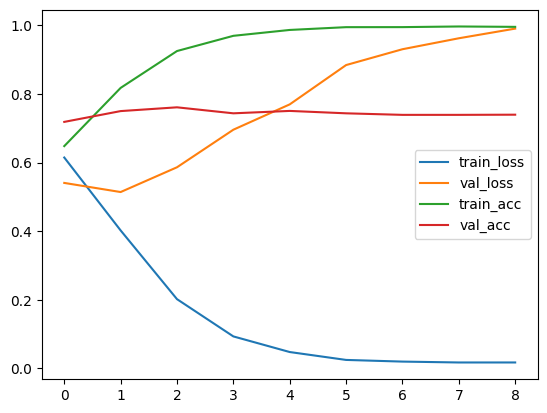

In [72]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBED_DIM = 128   

gru_model = GRUModel(
    vocab_size=VOCAB_SIZE,  
    embed_dim=EMBED_DIM,     
    hidden_units=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    pad_idx=PAD              
)

train_func(train_seq, train_target, gru_model)

### 5. 추론

In [73]:
import torch
import torch.nn.functional as F

# 예시 문장 여러개
texts = [
    "오늘 정말 기분이 좋아! 너무 신난다.",       
    "왜 이렇게 짜증나고 화가 나는지 모르겠다.",   
    "불안하고 초조해서 잠이 오지 않아.",         
    "조금 아쉽지만 그래도 괜찮은 하루였어.",
    "너무 힘들어",
    "너무 졸려서 힘들어"       
]

# 텍스트 -> 정수 시퀀스로 변환
ids = [text_to_ids(s, vocab, max_len=150) for s in texts]
seqs = torch.tensor(ids, dtype=torch.long)  

# 모델 추론
gru_model.eval()
with torch.no_grad():
    logits = gru_model(seqs).squeeze(-1)   
    probs = torch.sigmoid(logits)          
    preds = (probs > 0.5).long()            

# 결과 출력
for s, p, pr in zip(texts, preds.tolist(), probs.tolist()):
    senti = "긍정" if p == 1 else "부정"
    print(f"[문장] {s}")
    print(f" → 예측: {senti} (확률={pr:.2f})\n")


[문장] 오늘 정말 기분이 좋아! 너무 신난다.
 → 예측: 긍정 (확률=1.00)

[문장] 왜 이렇게 짜증나고 화가 나는지 모르겠다.
 → 예측: 부정 (확률=0.00)

[문장] 불안하고 초조해서 잠이 오지 않아.
 → 예측: 부정 (확률=0.00)

[문장] 조금 아쉽지만 그래도 괜찮은 하루였어.
 → 예측: 긍정 (확률=1.00)

[문장] 너무 힘들어
 → 예측: 부정 (확률=0.00)

[문장] 너무 졸려서 힘들어
 → 예측: 부정 (확률=0.00)

